# Robot Self-Modeling Dataset Generation

## Overview

This notebook generates synthetic training data for robot self-modeling from PyBullet simulation. The main goal is to create a large dataset of robot poses paired with visual observations. Each sample consists of a silhouette image of the robot and the corresponding joint angles that produced that pose.

The approach uses Lorenz attractors to generate smooth, natural-looking motion trajectories that explore the robot's workspace. Rather than using random or predefined trajectories, Lorenz chaos provides motion patterns that are smooth yet unpredictable, allowing the dataset to cover diverse poses without artificial looking jumps between them.

In [2]:
!pip install pybullet
import os
import time
import numpy as np
import pybullet as p
import pybullet_data
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## File and Path Configuration

The notebook uses Google Drive to store both the robot URDF file (the model definition) and the generated dataset. Setting up the paths and directories at the start ensures the data can be saved and won't get lost when the Colab session ends.

The robot model is a 4-degree-of-freedom arm. All configuration values like image resolution and camera distance are defined in one place so they can be easily adjusted for future experiments.

In [3]:
# 2. Configuration
BASE_DIR = "/content/drive/MyDrive/robot_self_modelling/RobotArmURDF"
URDF_PATH = os.path.join(BASE_DIR, "4dof_1st/urdf/4dof_1st.urdf")
SAVE_DIR = "/content/drive/MyDrive/robot_self_modelling/data/sim_data"

os.makedirs(SAVE_DIR, exist_ok=True)

print(f"URDF Path: {URDF_PATH}")
print(f"Save Directory: {SAVE_DIR}")

URDF Path: /content/drive/MyDrive/robot_self_modelling/RobotArmURDF/4dof_1st/urdf/4dof_1st.urdf
Save Directory: /content/drive/MyDrive/robot_self_modelling/data/sim_data


## Helper Functions

These utility functions handle coordinate transformations for rotation matrices. They're included for flexibility but not used in the main data generation pipeline, which passes joint angles directly to PyBullet's physics engine.

In [4]:
def rot_Z(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s, 0, 0], [s, c, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

def rot_Y(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, 0, s, 0], [0, 1, 0, 0], [-s, 0, c, 0], [0, 0, 0, 1]])

def green_black(img):
    img = np.array(img)
    mask = cv2.inRange(img[..., 1], 100, 255)
    img[mask > 0] = (255, 255, 255)
    return img

## PyBullet Simulation Environment Class

The FBVSM_Env class wraps PyBullet to create a consistent interface for generating robot observations. DIRECT mode runs the physics simulation without rendering, which is much faster for batch data generation.

The camera is positioned at a fixed viewpoint (1.5 meters away, 45-degree elevation) to consistently observe the end-effector movements. Each joint command runs through 50 simulation steps (200 ms physical time) to allow the robot to settle. Images are captured from the default camera as grayscale 100×100 arrays. The joint commands are expected in normalized form [0, 1] and are mapped to physical angles [-90°, +90°].

In [5]:
!pip install pybullet
import os
import time
import numpy as np
import pybullet as p
import pybullet_data
import cv2
import matplotlib.pyplot as plt
from google.colab import drive

class FBVSM_Env:
    def __init__(self, urdf_path, width=400, height=400, cam_dist=1.0):
        self.urdf_path = urdf_path
        self.width = width
        self.height = height
        self.cam_dist = cam_dist
        self.num_motor = 4
        self.camera_fov = 42

        self.view_theta = 0
        self.view_phi = 0

        self.physicsClient = p.connect(p.DIRECT)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())

        self.camera_pos = [cam_dist, 0, 0]
        self.view_matrix = p.computeViewMatrix(
            cameraEyePosition=self.camera_pos,
            cameraTargetPosition=[0, 0, 0],
            cameraUpVector=[0, 0, 1]
        )
        self.projection_matrix = p.computeProjectionMatrixFOV(
            fov=self.camera_fov,
            aspect=1.0,
            nearVal=0.1,
            farVal=100
        )

        self.reset()

    def reset(self):
        p.resetSimulation()
        p.setGravity(0, 0, -9.8)

        plane_visual_shape_id = p.createVisualShape(
            shapeType=p.GEOM_PLANE,
            rgbaColor=[1, 1, 1, 1],
            planeNormal=[0, 0, 1]
        )
        p.createMultiBody(
            baseMass=0,
            baseVisualShapeIndex=plane_visual_shape_id,
            basePosition=[0, 0, -0.109]
        )

        try:
            self.robot_id = p.loadURDF(self.urdf_path, [0, 0, -0.108], p.getQuaternionFromEuler([0, 0, -np.pi/2]), useFixedBase=1)
        except Exception as e:
            print(f"Error loading URDF: {e}")
            print("Please check if the path is correct and the file exists.")
            raise e

        for i in range(p.getNumJoints(self.robot_id)):
            p.resetJointState(self.robot_id, i, 0)

        colors = [
            [1, 0, 0, 1],
            [0, 1, 0, 1],
            [0, 0, 1, 1],
            [1, 1, 0, 1],
        ]
        for i in range(self.num_motor):
            p.changeVisualShape(self.robot_id, i, rgbaColor=colors[i])

    def step(self, action):
        target_angles = np.array(action) * (np.pi / 2)

        for i in range(self.num_motor):
            p.setJointMotorControl2(
                bodyUniqueId=self.robot_id,
                jointIndex=i,
                controlMode=p.POSITION_CONTROL,
                targetPosition=target_angles[i],
                force=100
            )

        for _ in range(50):
            p.stepSimulation()

        img_arr = p.getCameraImage(
            self.width, self.height,
            self.view_matrix, self.projection_matrix,
            renderer=p.ER_TINY_RENDERER,
            shadow=0
        )

        rgb = np.reshape(img_arr[2], (self.height, self.width, 4))[:, :, :3]

        joint_states = []
        for i in range(self.num_motor):
            state = p.getJointState(self.robot_id, i)
            joint_states.append(state[0] / (np.pi / 2))

        return np.array(joint_states), rgb

    def close(self):
        p.disconnect()

## Lorenz Attractor-Based Trajectory Generation

The dataset uses Lorenz attractors to generate smooth, diverse robot trajectories. This is much better than random angle sequences because Lorenz trajectories are naturally smooth—they follow continuous paths through the state space instead of jumping between random positions.

The Lorenz system is chaotic, meaning it fills a region of the state space densely but never repeats exactly. This generates trajectories that explore many different robot configurations without becoming stuck or repeating. Two independent Lorenz systems with slightly different parameters are mixed together to drive the four robot joints independently.

The implementation uses 4th-order Runge-Kutta integration (RK4) to numerically solve the ODE. This is more accurate than simple Euler stepping and prevents numerical instabilities that could cause trajectories to diverge. After integration, the trajectory values are scaled and clipped to the valid joint angle range [-90°, +90°]. The step size (dt = 0.01) and scale factors are tuned to keep joint velocities reasonable.

Generating 2000 samples using Lorenz attractor...

--- Debugging Sample 0 ---
Raw RGB image shape: (100, 100, 3), min: 0, max: 255
Grayscale image shape: (100, 100), min: 0.068, max: 1.000
Segmented image shape: (100, 100), min: 0, max: 255


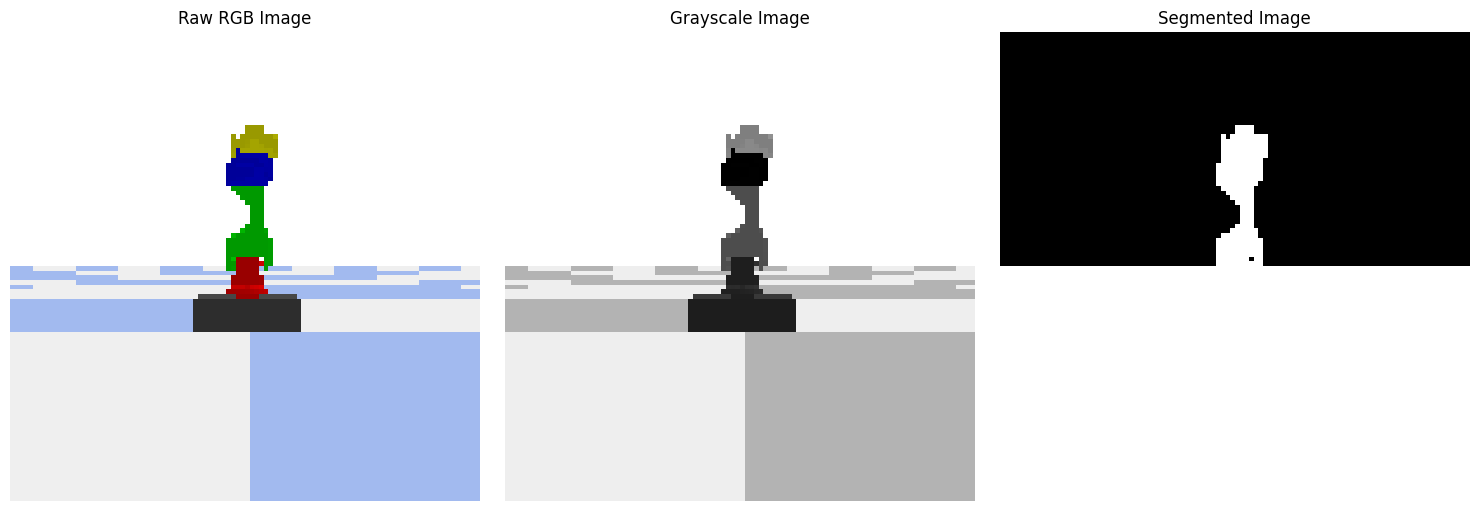

------------------------
Sample 200/2000 - Joints: [-18.4 -21.5 -14.1  47.3]
Sample 400/2000 - Joints: [-22.4 -23.7 -16.2  51.1]
Sample 600/2000 - Joints: [-21.  -16.4 -21.   53.6]
Sample 800/2000 - Joints: [-15.1 -10.1 -17.4  41.2]
Sample 1000/2000 - Joints: [-10.7  -8.7  -6.3  41.9]
Sample 1200/2000 - Joints: [-7.2 -4.8 -4.9 41. ]
Sample 1400/2000 - Joints: [ 21.   36.9 -12.3  24. ]
Sample 1600/2000 - Joints: [-15.6 -25.2  17.3  40. ]
Sample 1800/2000 - Joints: [ 1.5 -1.8  7.1 47.8]
Generation complete in 64.1s (31.2 samples/sec)

=== Data Summary ===
Images shape: (2000, 100, 100)
Angles shape: (2000, 4)
Image range: [0.000, 255.000]
Angle columns: [j1, j2, j3, j4]

Data saved to: /content/drive/MyDrive/robot_self_modelling/data/sim_data/sim_data_robo1_lorenz_colab_2000.npz


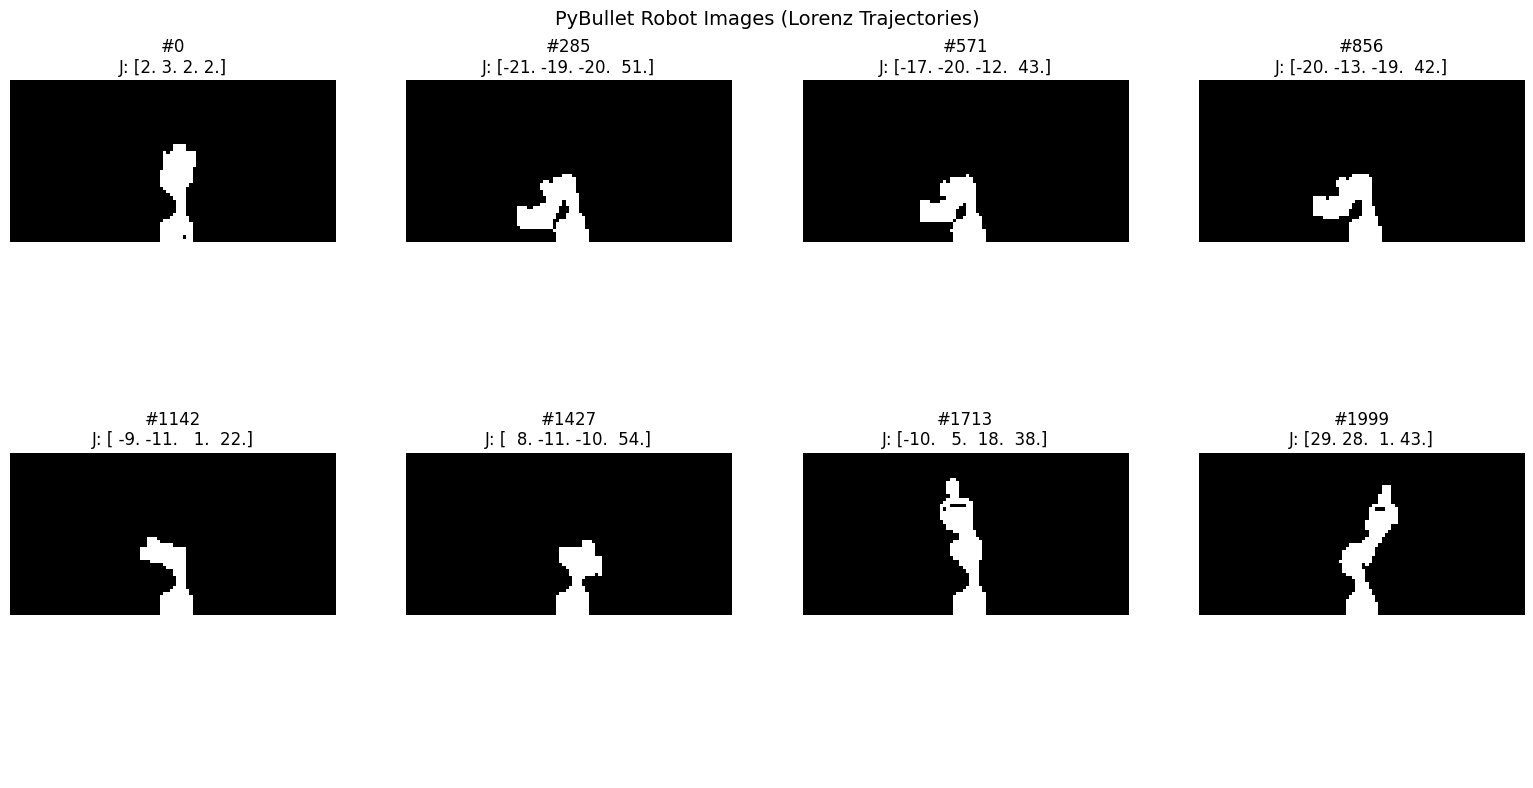

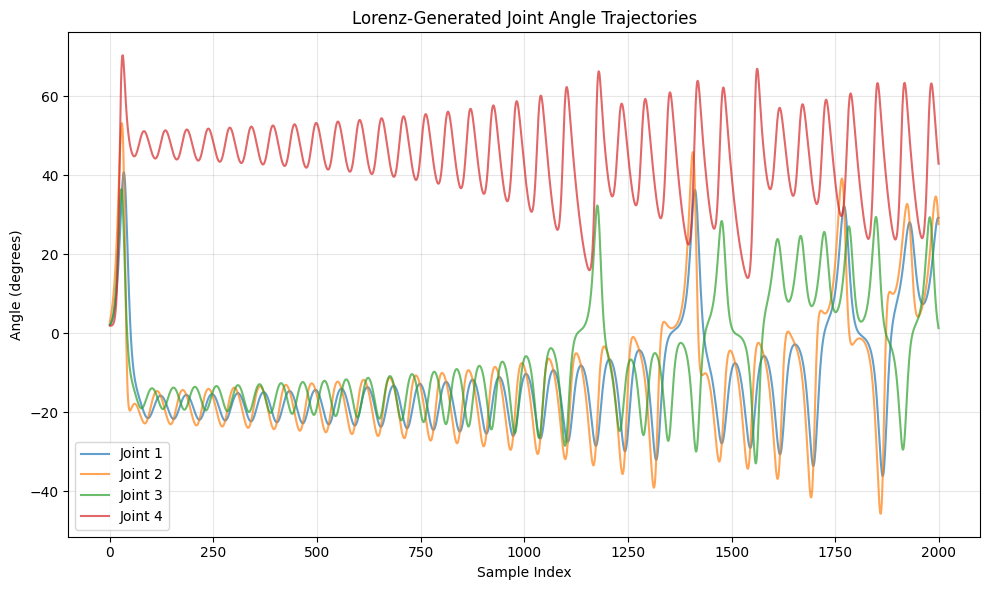


Data generation complete!


In [7]:
import os
import time
import numpy as np
import pybullet as p
import pybullet_data
import cv2
import matplotlib.pyplot as plt

def lorenz_system(state, sigma=10.0, rho=28.0, beta=8.0/3.0):

    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return np.array([dx, dy, dz])

def generate_lorenz_trajectory(num_steps, dt=0.01, scale=0.02):
    # Initial state (near attractor)
    state = np.array([1.0, 1.0, 1.0])
    trajectory = []

    # Use Runge-Kutta 4th order for stable integration
    for _ in range(num_steps):
        k1 = lorenz_system(state)
        k2 = lorenz_system(state + dt/2 * k1)
        k3 = lorenz_system(state + dt/2 * k2)
        k4 = lorenz_system(state + dt * k3)

        state = state + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

        # Scale and clip to [-1, 1]
        scaled = np.tanh(state * scale)
        trajectory.append(scaled)

    return np.array(trajectory)

def generate_data_lorenz(env, num_samples=2000):

    print(f"Generating {num_samples} samples using Lorenz attractor...")

    images = []
    angles = []

    start_time = time.time()

    traj1 = generate_lorenz_trajectory(num_samples, dt=0.01, scale=0.025)
    traj2 = generate_lorenz_trajectory(num_samples, dt=0.012, scale=0.022)

    for i in range(num_samples):
        action = np.array([
            traj1[i, 0],
            traj1[i, 1],
            traj2[i, 0],
            traj2[i, 2],
        ])

        action = np.clip(action, -1, 1)

        obs_angle, obs_img = env.step(action)

        norm_img = obs_img.astype(np.float32) / 255.0
        gray_img = cv2.cvtColor(norm_img, cv2.COLOR_RGB2GRAY)

        segmented_img = (gray_img < (240 / 255.0)).astype(np.uint8) * 255
        images.append(segmented_img)

        joint_angles = action * 90
        angles.append(joint_angles)

        if i == 0:
            print(f"\n--- Debugging Sample {i} ---")
            print(f"Raw RGB image shape: {obs_img.shape}, min: {obs_img.min()}, max: {obs_img.max()}")
            print(f"Grayscale image shape: {gray_img.shape}, min: {gray_img.min():.3f}, max: {gray_img.max():.3f}")
            print(f"Segmented image shape: {segmented_img.shape}, min: {segmented_img.min()}, max: {segmented_img.max()}")

            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(obs_img)
            plt.title('Raw RGB Image')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(gray_img, cmap='gray')
            plt.title('Grayscale Image')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(segmented_img, cmap='gray')
            plt.title('Segmented Image')
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            print("------------------------")

        if i % 200 == 0 and i > 0:
            print(f"Sample {i}/{num_samples} - Joints: {joint_angles.round(1)}")

    elapsed = time.time() - start_time
    print(f"Generation complete in {elapsed:.1f}s ({num_samples/elapsed:.1f} samples/sec)")

    return np.array(images), np.array(angles)

try:
    env = FBVSM_Env(URDF_PATH, width=100, height=100)

    num_samples = 2000
    images, angles = generate_data_lorenz(env, num_samples)

    print(f"\n=== Data Summary ===")
    print(f"Images shape: {images.shape}")
    print(f"Angles shape: {angles.shape}")
    print(f"Image range: [{images.min():.3f}, {images.max():.3f}]")
    print(f"Angle columns: [j1, j2, j3, j4]")

    focal_length = 130.2545
    save_path = os.path.join(SAVE_DIR, f"sim_data_robo1_lorenz_colab_{num_samples}.npz")

    np.savez(save_path,
             images=images,
             angles=angles,
             focal=np.array(focal_length),
             poses=np.zeros((num_samples, 4, 4))
            )

    print(f"\nData saved to: {save_path}")

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    sample_idx = np.linspace(0, num_samples-1, 8, dtype=int)

    for i, ax in enumerate(axes.flat):
        idx = sample_idx[i]
        ax.imshow(images[idx], cmap='gray')
        joints = angles[idx]
        ax.set_title(f'#{idx}\nJ: {joints.round(0)}')
        ax.axis('off')

    plt.suptitle('PyBullet Robot Images (Lorenz Trajectories)', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'lorenz_samples_preview.png'), dpi=100)
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 6))
    joint_angles = angles
    for j in range(4):
        ax.plot(joint_angles[:, j], label=f'Joint {j+1}', alpha=0.7)
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Angle (degrees)')
    ax.set_title('Lorenz-Generated Joint Angle Trajectories')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, 'lorenz_trajectory.png'), dpi=100)
    plt.show()

    env.close()
    print("\nData generation complete!")

except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()
    try:
        p.disconnect()
    except:
        pass

## Image Processing, Quality Verification and Storage

All images are captured as RGB but converted to grayscale to reduce storage and simplify the learning task. A threshold at value 240 converts the grayscale to binary—anything darker than 240 becomes black (the background), everything else becomes white (the robot).

The binary mask is a good representation because it's simple (just two values), it captures the robot's size and position clearly, and it keeps file sizes small. The first sample is shown to verify the segmentation worked correctly. The sample grid shows how diverse the robot configurations are—different arm positions appear in each image. The trajectory plot confirms motion is smooth without discontinuities or sudden jumps between positions.

The dataset is saved as a compressed NumPy .npz file, which stores multiple arrays together. Each sample includes:

- **Images** (shape 2000 × 100 × 100): Grayscale binary masks with values in [0, 255]
- **Angles** (shape 2000 × 4): Joint angles in degrees, range [-90, +90]
- **Focal length**: Camera intrinsic parameter for projection calculations
- **Camera poses**: The fixed camera position and orientation used for all captures

Total dataset size is about 2000 samples generated from 2000 independent Lorenz trajectories. The .npz format compresses well and loads quickly into memory with a single `np.load()` call. This makes it convenient for training neural networks without needing to regenerate data.